In [1]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch import nn
from torch.functional import F
from torch.optim import Adam
import numpy as np
from tqdm.auto import tqdm
import umap
import umap.plot
import pandas as pd
from warnings import filterwarnings

2022-11-05 11:46:45.773798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load MNIST

In [2]:
mnist_train = datasets.MNIST(root='mnist/',train=True,transform=ToTensor(),download=True)
mnist_test  = datasets.MNIST(root='mnist/',train=False,transform=ToTensor(),download=True)

In [3]:
train_loader = DataLoader(dataset=mnist_test,batch_size=32)
test_loader = DataLoader(dataset=mnist_train,batch_size=32)

In [4]:
filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Add noise

In [5]:
def add_noise(tensor,std=0.7,mean=0.):
    
    return tensor + torch.normal(mean,std,tensor.size())

# Visualize some samples

In [6]:
_, (example_data, example_targets) = next(enumerate(train_loader))
denoised_example = add_noise(example_data)

In [7]:
def visualize_dataset(example_data,example_targets,channel_size):
    
    if channel_size==3:
        fig = plt.figure()
        
        for i in range(6):
            plt.subplot(2,3,i+1)
            plt.tight_layout()
            plt.imshow(np.transpose(example_data[i],(1, 2, 0)))
            plt.title("Ground Truth: {}".format(example_targets[i]))
            plt.xticks([])
            plt.yticks([])
        
    if channel_size == 1:
        fig = plt.figure()
        for i in range(6):
            plt.subplot(2,3,i+1)
            plt.tight_layout()
            plt.imshow(example_data[i][0], cmap='gray')
            plt.title("Ground Truth: {}".format(example_targets[i]))
            plt.xticks([])
            plt.yticks([])

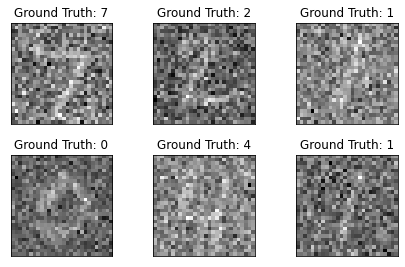

In [9]:
visualize_dataset(example_data=denoised_example,example_targets=example_targets,channel_size=1)

# Create the model

In [10]:
class DenoisingAE(nn.Module):
    
    def __init__(self):
        super(DenoisingAE,self).__init__()
        
        self.encoder = nn.Sequential(
            
            nn.Linear(28*28,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,10),
            nn.ReLU(),
        
        )
        
        self.decoder = nn.Sequential(
            
            nn.Linear(10,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,28*28),
            nn.ReLU(),
        )
        
    
    def forward(self,x):
        
        x = x.view(x.size(0),-1)
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x
    
        

In [11]:
model_relu = DenoisingAE()

In [12]:
model_relu

DenoisingAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): ReLU()
  )
)

# Train the model

In [13]:
optimizer = Adam(model_relu.parameters(),lr=1e-3)
criterion = torch.nn.MSELoss()
EPOCH = 20

In [14]:
def train(model,train_dataloader,optimizer,criterion,EPOCH):
    
    with tqdm(total=len(train_dataloader)*EPOCH) as tt:
        
        for epoch in range(EPOCH):

            total_loss, batch_count = 0, 0
            for idx, (batch,_) in enumerate(train_dataloader):

               ##################################
                denoised_data = add_noise(batch)
               ##################################


                output = model(denoised_data)

                loss = criterion(output,batch.view(batch.size(0),-1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


                total_loss += loss.item()
                batch_count += 1
                tt.update()

            total_loss = total_loss / batch_count
            print(f'{total_loss}')
            

In [15]:
train(model=model_relu,train_dataloader=train_loader,optimizer=optimizer,criterion=criterion,EPOCH=EPOCH)

  0%|          | 0/6260 [00:00<?, ?it/s]

0.06812095567107962
0.051239361599706615
0.04599885571117218
0.04287673928105412
0.040784892658836926
0.0394480559534539
0.0386675090228502
0.037951035014451885
0.03707223249890934
0.03642070194045766
0.03592083440682949
0.03567343574767105
0.03520301338463736
0.034785671219134486
0.03426961278834473
0.03365871578621598
0.033380766783040555
0.03321190421787885
0.03307468326280292
0.03276087806676142


# Visualize the results

In [18]:
def visualize_result(model,dataloader):    
    
    dataiter = iter(dataloader)
    images, labels = dataiter.next()
    
    batch_size = images.size(0)
    channel_size = images.size(1)
    w_h = images.size(2)
    
    denoised_images = add_noise(images)
    images_flatten = denoised_images.view(images.size(0), -1)
    
    output = model(images_flatten)
    images = images.numpy()
    output = output.view(batch_size, channel_size, w_h, w_h)
    output = output.detach().numpy()

    fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    for images, row in zip([denoised_images, images, output], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

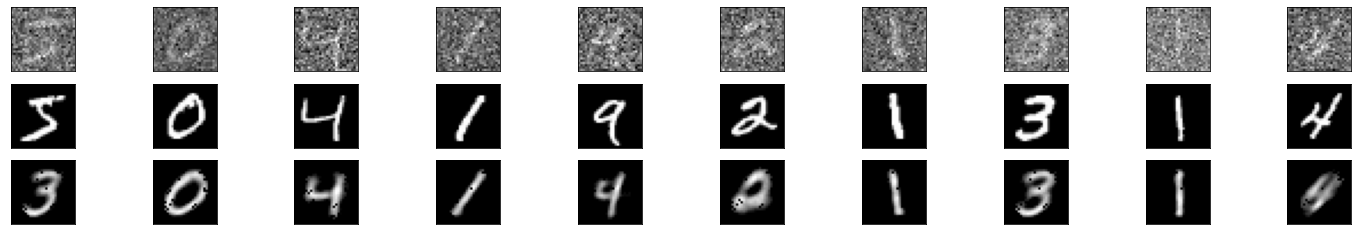

In [19]:
visualize_result(model=model_relu,dataloader=test_loader)

# Another implementation with Leaky ReLU

In [23]:
class Encoder(nn.Module):
    
    def __init__(self):
        
        super(Encoder,self).__init__()
        
        
        self.encode = nn.Sequential(
            nn.Linear(28*28,128),
            nn.LeakyReLU(),
            nn.Linear(128,64),
            nn.LeakyReLU(),
            nn.Linear(64,10),
            nn.LeakyReLU(),
        
        )
        
        
    def forward(self,x):
        #print("Encoder:",x.shape)
        x = x.view(x.size(0),-1)
        x = self.encode(x)
        
        return x

In [24]:
class Decoder(nn.Module):
    
    def __init__(self):
        
        super(Decoder,self).__init__()
        
        self.decode = nn.Sequential(
        
            nn.Linear(10,64),
            nn.LeakyReLU(),
            nn.Linear(64,128),
            nn.LeakyReLU(),
            nn.Linear(128,28*28),
            nn.LeakyReLU()
        
        )
        
    def forward(self,x):
        #print("Decoder:",x.shape)
        x = self.decode(x)
        
        return x

In [25]:
class DenoisingAE(nn.Module):
    
    def __init__(self):
        
        super(DenoisingAE,self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self,x):
        #print("AE:",x.shape)
        x = self.encoder(x)
        x = self.decoder(x)
        #print(x)

        return x

In [26]:
model_lrelu = DenoisingAE()

In [27]:
model_lrelu

DenoisingAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=64, out_features=10, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
    )
  )
  (decoder): Decoder(
    (decode): Sequential(
      (0): Linear(in_features=10, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=128, out_features=784, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
    )
  )
)

In [28]:
optimizer = Adam(model_lrelu.parameters(),lr=2e-3)
criterion = torch.nn.MSELoss()
EPOCH = 20

In [29]:
train(model=model_lrelu,train_dataloader=train_loader,optimizer=optimizer,criterion=criterion,EPOCH=EPOCH)

  0%|          | 0/6260 [00:00<?, ?it/s]

0.055719407364583244
0.04585753331264368
0.04255276193586401
0.04001963208206355
0.037740088338716726
0.03603918764133233
0.03503230506905351
0.03398548264782459
0.03324865016003196
0.032760480156959815
0.03217814024835349
0.03166372641421164
0.03132752508234483
0.031037705703474843
0.03085030307665991
0.030536544589569774
0.03038499851267749
0.030083882797973607
0.02995151532486605
0.02985781299087186


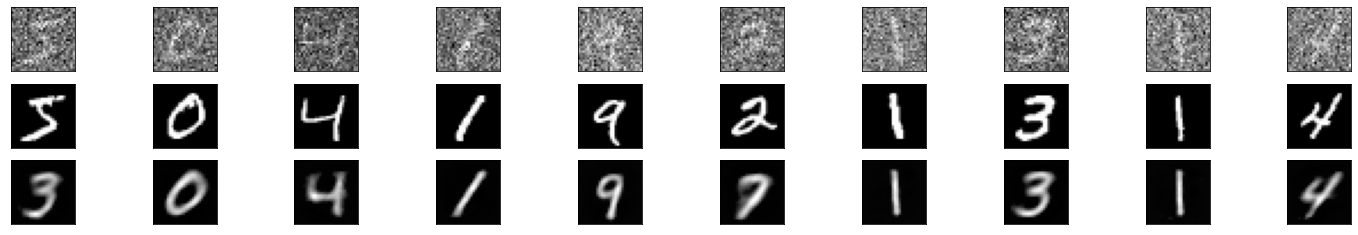

In [30]:
visualize_result(model=model_lrelu,dataloader=test_loader) 

# Visualize Latent Space (Optional HW)

In [74]:
from helpers import visualize2d
from helpers import visualize2d_interactive

# Denoising Autoencoder with F-MNIST (Optional HW)

In [75]:
fmnist_train = None
fmnist_test  = None

In [77]:
fmnist_train_loader = None
fmnist_test_loader = None

In [79]:
batch_idx, (fmnist_example_data, fmnist_example_targets) = next(enumerate(fmnist_train_loader))
denoised_example = None